# Использование функционала PyTorch и библиотеки MIHA для задачи заполнения пропусков

Задача: восстановление пропусков в спутниковых снимках для территории 1 градус широты на 1 градус долготы (г. Мадрид). Массивы данных для обучения и валидации уже стандартизированны. Минимальными значениями в каждой матрице закодированы пропуски.

In [2]:
import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm

from pylab import rcParams
rcParams['figure.figsize'] = 18, 7

import warnings
warnings.filterwarnings("ignore")

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable

import torch.utils.data as data_utils

Определим параметры для воспроизводимости результатов в будущем.

In [7]:
random_seed = 100
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

Функция для подготовки данных и их разделения на обучение и тест. Так как для данного пример размер матриц 110 на 88 элементов, то для большей наглядности мы не будем использовать какие-либо переменные и алгоритмы автоматического определения размерностей матриц, а укажем эти значения явно.

In [15]:
def prepare_data(x_path, y_path, train_vs_test = 2000):
    """
    Функция позволяет по заданному пути загрузить обучающую выборку и тестовую
    
    :param x_path: путь до npy массива с признаками
    :param y_path: путь до npy массива с отликом
    :param train_vs_test: по какому индексу разделить датасет на train и test
    """

    # Загружаем данные 
    X = np.load(x_path)
    Y = np.load(y_path)

    # Разделяем на "обучение" и "тест" и переводим в тензоры
    X_train = torch.from_numpy(X[:train_vs_test,:,:,0])
    X_test = torch.from_numpy(X[train_vs_test:, :, :,0])
    Y_train = torch.from_numpy(Y[:train_vs_test,:,:,0])
    Y_test = torch.from_numpy(Y[train_vs_test:, :, :,0])
    
    # Сколько матриц будет в тестовой выборке
    len_test = len(Y_test)
    
    # Меняем форму тензоров 
    X_train = torch.reshape(X_train, (train_vs_test, 1, 110, 88))
    X_test = torch.reshape(X_test, (len_test, 1, 110, 88))
    Y_train = torch.reshape(Y_train, (train_vs_test, 1, 110, 88))
    Y_test = torch.reshape(Y_test, (len_test, 1, 110, 88))

    print(f'Размерность массива в обучающей выборке {Y_train.shape}')
    print(f'Размерность массива в тестовой выборке {Y_test.shape}')
    
    # Конвертируем матрицы из numpy формата
    train = data_utils.TensorDataset(X_train, Y_train)
    test = data_utils.TensorDataset(X_test, Y_test)
    
    return(train, test, X_train, X_test, Y_train, Y_test)


train, test, X_train, X_test, Y_train, Y_test = prepare_data(x_path='D:/Madrid_LST_neural_network/Train/X.npy', 
                               y_path='D:/Madrid_LST_neural_network/Train/Y.npy', 
                               train_vs_test=2000)

Размерность массива в обучающей выборке torch.Size([2000, 1, 110, 88])
Размерность массива в тестовой выборке torch.Size([658, 1, 110, 88])


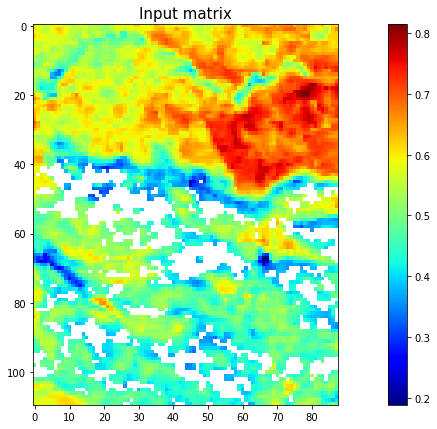

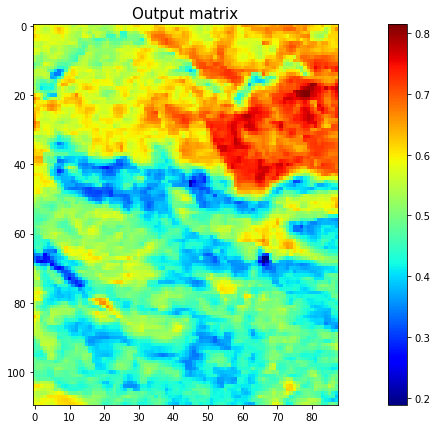

In [16]:
def plot_matrix(matrix, name, is_input = False):
    """
    Функция позволяет отрисовать нужную матрицу
    
    :param matrix: матрица, чтобы её отрисовать
    :param name: название матрицы
    :param is_input: является ли матрица входной для алгоритма
    """
    
    matrix = np.array(matrix)
    if is_input == True:
        matrix = np.ma.masked_where(matrix == np.min(matrix), matrix)
    else:
        pass
    
    plt.imshow(matrix, cmap='jet')
    plt.title(name, fontsize=15)
    plt.colorbar()
    plt.show()

# Посмотрим на то, как выглядят 
plot_matrix(matrix=X_train[13,0,:,:], name='Input matrix', is_input=True)
plot_matrix(matrix=Y_train[13,0,:,:], name='Output matrix')

Если требуется сохранить матрицы в pt формате, используйте команду 'torch.save'.

## Свёрточная нейронная сеть

Перейдем к нейронной сети. Представим её в следующем виде.

In [63]:
# Define the Convolutional Autoencoder
class ConvNet(nn.Module):
    def __init__(self):
        
        # Переопределяем методы родительского класса для автоэнкодера
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(1, 16, kernel_size=2, stride=1, padding=1), nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(nn.Conv2d(16, 32, kernel_size=2, stride=1, padding=1), nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=1))
        self.layer3 = nn.Sequential(nn.Conv2d(32, 16, kernel_size=2, stride=1, padding=1), nn.ReLU(), nn.Upsample(scale_factor=0.99, mode='nearest'))
        self.layer4 = nn.Sequential(nn.Conv2d(16, 1, kernel_size=2, stride=1, padding=1), nn.ReLU(), nn.Upsample(scale_factor=1.97, mode='bilinear'))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        return(out)
    
#Instantiate the model
model = ConvNet()

#Loss function
criterion = nn.MSELoss()

#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Prepare data loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=32, num_workers=0)
test_loader = torch.utils.data.DataLoader(test, batch_size=32, num_workers=0)

Обучать нейронную сеть мы будем на видеокарте. Произведем необходимые приготовления.

In [64]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

In [65]:
#Epochs
n_epochs = 50

train_losses = []
test_losses = []

device = get_device()
model.to(device)

for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    test_loss = 0.0

    # Обучение
    for images, target in train_loader:
        # Переносим эти матрицы на GPU
        images = images.to(device)
        target = target.to(device)
        
        # Обновляем градиенты 
        optimizer.zero_grad()
        
        # Предсказание нейронной сети
        outputs = model(images)   
        
        # Замеряем разницу между действительными значениями и предсказанием
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*target.size(0)
        
    # Проверка точности на тестовых данных
    for test_images, test_target in test_loader:
        # Переносим эти матрицы на GPU
        test_images = test_images.to(device)
        test_target = test_target.to(device)
        
        # Предсказание нейронной сети
        val_outputs = model(test_images)      
        
        # Замеряем разницу между действительными значениями и предсказанием
        t_loss = criterion(val_outputs, test_target)
        test_loss += t_loss.item()*test_target.size(0)
          
    train_loss = train_loss/len(train_loader)
    test_loss = test_loss/len(test_loader)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)

Визуализируем ход обучения

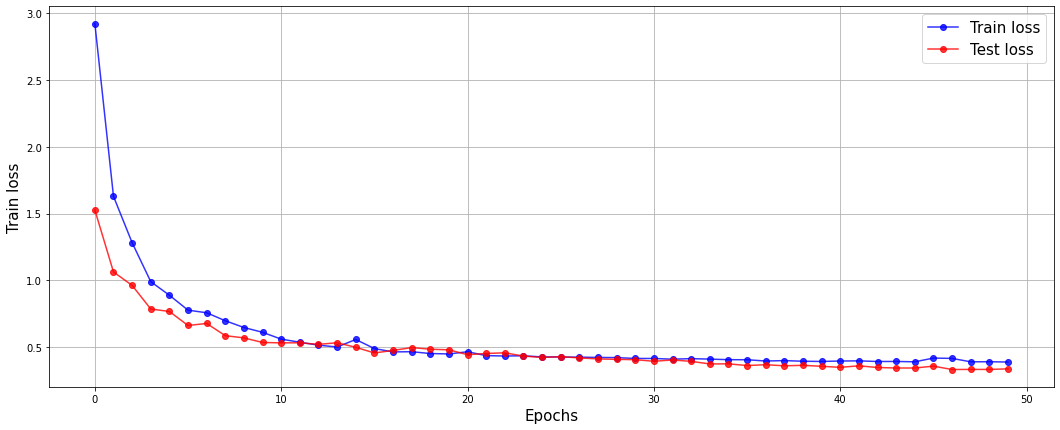

In [66]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 7

plt.plot(train_losses, '-ok', c='blue', alpha=0.8, label='Train loss')
plt.plot(test_losses, '-ok', c='red', alpha=0.8, label='Test loss')
plt.legend(fontsize=15)
plt.ylabel('Train loss', fontsize=15)
plt.xlabel('Epochs', fontsize=15)
plt.grid()
plt.show()

Подготовим функцию для отображения предсказанной матрицы.

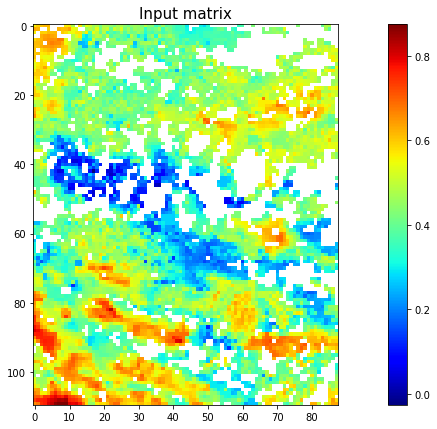

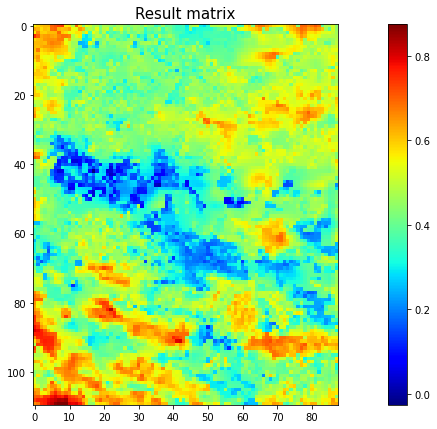

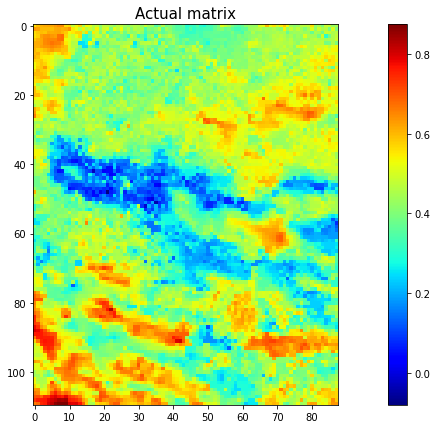

In [67]:
def show_prediction(matrix_index, X_test, Y_test, model):
    
    # Перемещаем матрицу на CPU (если требуется)
    cpu_real = X_test[matrix_index, :, :, :].cpu()
    input_matrix = cpu_real.data.numpy()
    input_matrix = input_matrix[0,:,:]
    
    predicted_matrix = np.copy(input_matrix)
    plot_matrix(matrix=input_matrix, name='Input matrix', is_input=True)

    # Теперь данную матрицу переводим на GPU
    test_value = Variable(X_test[matrix_index, :, :, :].cuda())
    test_value = test_value.float()
    test_value = test_value.unsqueeze(0)

    # Делаем предсказание
    prediction = model(test_value)

    # Результат переносим на CPU
    cpu_pred = prediction.cpu()
    result = cpu_pred.data.numpy()
    result_matrix = result[0,0,:,:]
        
    predicted_matrix[input_matrix == np.min(input_matrix)] = result_matrix[input_matrix == np.min(input_matrix)]
    plot_matrix(matrix=predicted_matrix, name='Result matrix', is_input=False)
    
    cpu_real = Y_test[matrix_index, :, :, :].cpu()
    actual_matrix = cpu_real.data.numpy()
    actual_matrix = actual_matrix[0,:,:]
    
    plot_matrix(matrix=actual_matrix, name='Actual matrix', is_input=False)

show_prediction(matrix_index = 15, X_test = X_test, Y_test = Y_test, model = model)

Посмотрим на ещё один тестовый пример.

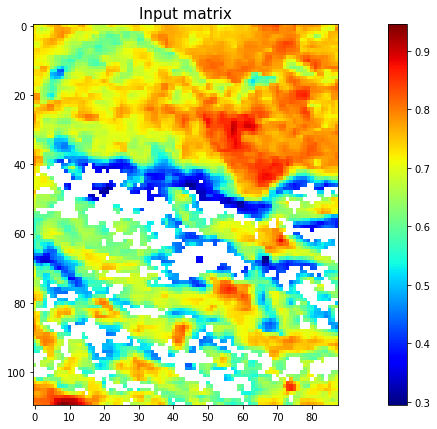

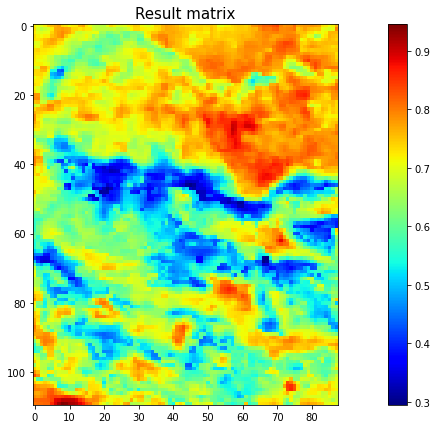

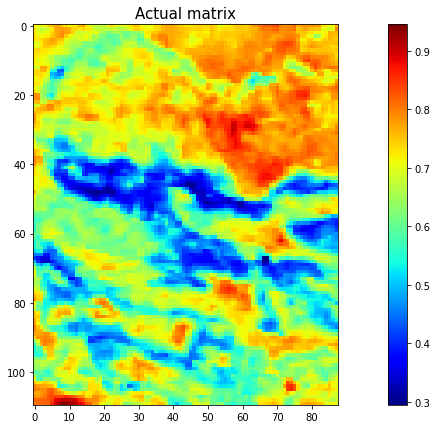

In [68]:
show_prediction(matrix_index = 17, X_test = X_test, Y_test = Y_test, model = model)

### ЛУЧШЕЕ ЗНАЧЕНИЕ TRAIN LOSS (MSE) ДЛЯ ИЗНАЧАЛЬНО ПРЕДЛОЖЕННОГО РЕШЕНИЯ - 0.38 

## Сравнение с моделью, полученной при помощи алгоритма MIHA

Теперь заргузим модель, которую удалось обучить при помощи алгоритма MIHA.

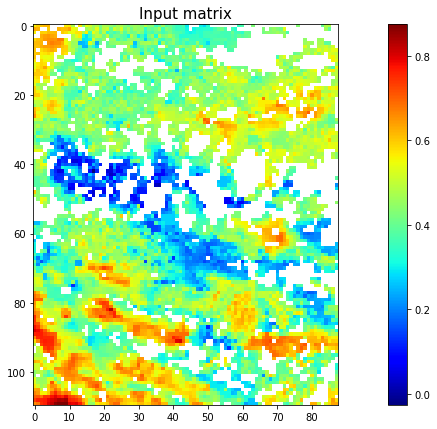

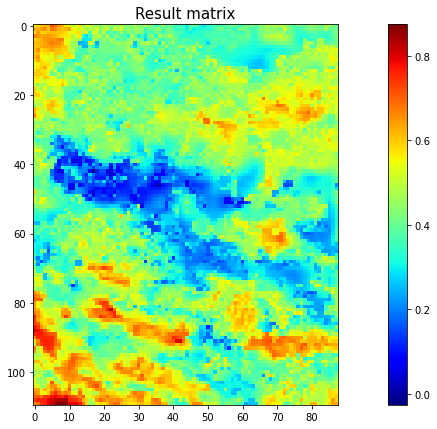

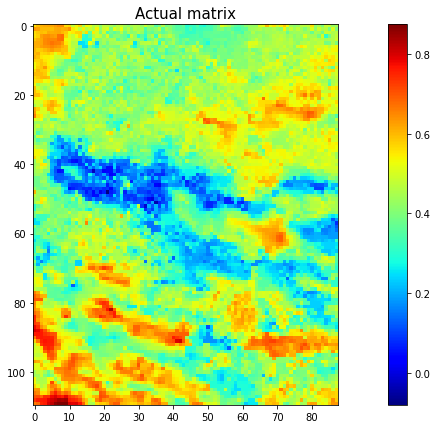

In [53]:
from torch import jit

net = jit.load('D:/miha_exp/3/model/model_final.zip')
state = torch.load('D:/miha_exp/3/model/optimizer_final.pth')

# Переносим нашу модель на GPU
device = get_device()
# Далее мы можем продолжить тренировать нашу нейронную сеть
net = net.train(mode=True)
net = net.to(device)

# Загружаем оптимизатор
optimizer = torch.optim.Adam(net.parameters())
optimizer.load_state_dict(state['optimizer'])

show_prediction(matrix_index = 15, X_test = X_test, Y_test = Y_test, model = net)

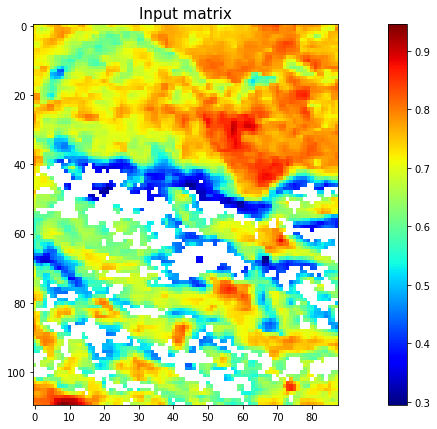

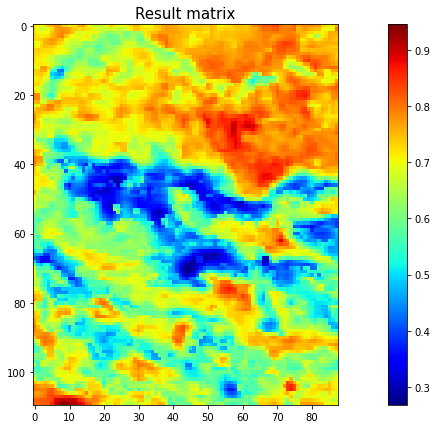

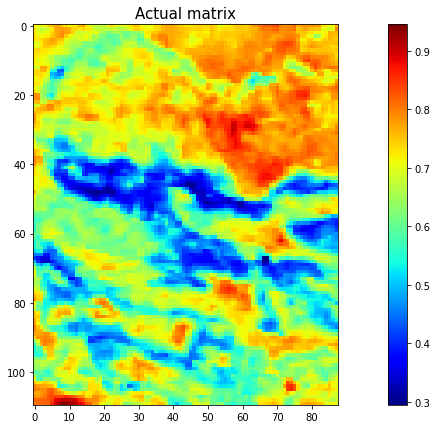

In [54]:
show_prediction(matrix_index = 17, X_test = X_test, Y_test = Y_test, model = net)

### ЛУЧШЕЕ ЗНАЧЕНИЕ TRAIN LOSS (MSE) ДЛЯ РЕШЕНИЯ, ПОЛУЧЕННОГО ПРИ ПОМОЩИ MIHA - 0.13